In [1]:
!nvidia-smi

Sat May 24 00:14:49 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 572.42                 Driver Version: 572.42         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   52C    P8             10W /   40W |    1805MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# library


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F
from torch.amp.autocast_mode import autocast
from torch.amp.grad_scaler import GradScaler
from tqdm.notebook import tqdm
from collections import defaultdict
from sklearn.decomposition import PCA
import os

# Constant

In [4]:
BATCH_SIZE = 32
EPOCHS = 200
LEARNING_RATE = 0.0001 
NUM_BANDS = 100  
PATIENCE = 20 
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# Load training and test data
train_df = pd.read_csv('C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/train.csv')
test_df = pd.read_csv('C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/test.csv')
base_path = 'C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot'

# Data Explore

Removing: sample2451.npy as it had a problem most of the time (Manually)

In [ ]:
# ============================================
#           Checking Shape of the Data         
# ============================================


def chunk_list(lst, chunk_size):
    for i in range(0, len(lst), chunk_size):
        yield lst[i:i + chunk_size]

shape_groups = defaultdict(list)

for filename in os.listdir(base_path):
    if filename.endswith('.npy'):
        file_path = os.path.join(base_path, filename)
        try:
            data = np.load(file_path)
            shape_groups[data.shape].append(filename)
        except Exception as e:
            print(f"⚠️ Failed to load {filename}: {e}")

# Display the grouped shapes horizontally with wrapping
print("📊 SHAPE GROUPS FOUND:")
for shape, files in shape_groups.items():
    print(f"\nShape {shape} | Total: {len(files)}")
    for chunk in chunk_list(files, 20):  # Wrap every 20 files
        print(" - " + ", ".join(chunk))

📊 SHAPE GROUPS FOUND:

Shape (128, 128, 125) | Total: 2681
 - sample1.npy, sample10.npy, sample100.npy, sample1000.npy, sample1001.npy, sample1002.npy, sample1003.npy, sample1005.npy, sample1006.npy, sample1007.npy, sample1008.npy, sample1009.npy, sample101.npy, sample1010.npy, sample1011.npy, sample1012.npy, sample1013.npy, sample1014.npy, sample1015.npy, sample1016.npy
 - sample1017.npy, sample1018.npy, sample1019.npy, sample102.npy, sample1020.npy, sample1021.npy, sample1022.npy, sample1023.npy, sample1024.npy, sample1025.npy, sample1026.npy, sample1027.npy, sample1028.npy, sample1029.npy, sample103.npy, sample1030.npy, sample1031.npy, sample1032.npy, sample1033.npy, sample1034.npy
 - sample1035.npy, sample1036.npy, sample1037.npy, sample1038.npy, sample1039.npy, sample104.npy, sample1040.npy, sample1041.npy, sample1042.npy, sample1043.npy, sample1044.npy, sample1045.npy, sample1046.npy, sample1047.npy, sample1048.npy, sample1049.npy, sample105.npy, sample1050.npy, sample1051.npy, s

Data shape: (128, 128, 125)
Label for sample1638.npy: 100


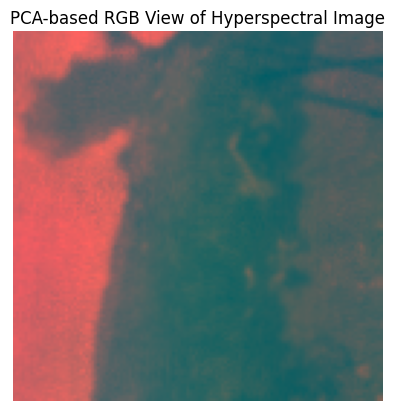

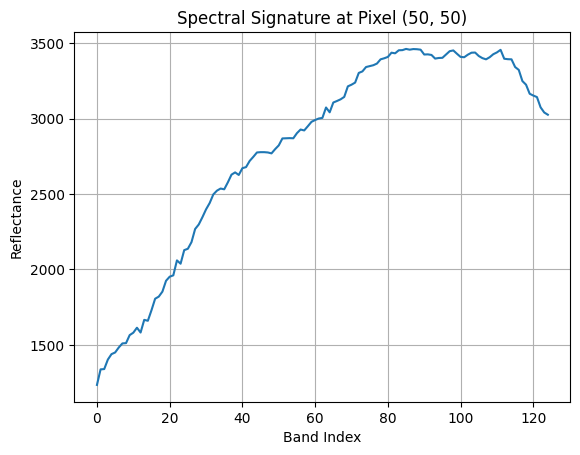

In [ ]:
# ============================================
#            Highest Value Data 
# ============================================


data_High = np.load(f'{base_path}/sample1638.npy')

print("Data shape:", data_High.shape)  # Print the shape of the data

# Get the label for this file from train_df
label = train_df[train_df['id'] == 'sample1638.npy']['label'].iloc[0]
print(f"Label for sample1638.npy: {label}")

# ---------- PCA Visualization ----------
H, W, C = data_High.shape
reshaped_data = data_High.reshape(-1, C)

# Apply PCA to reduce to 3 components
pca = PCA(n_components=3)
pca_data = pca.fit_transform(reshaped_data)

# Reshape back to image form
pca_image = pca_data.reshape(H, W, 3)

# Normalize for display
pca_image = (pca_image - np.min(pca_image)) / (np.max(pca_image) - np.min(pca_image))

# Display PCA RGB image
plt.imshow(pca_image)
plt.title("PCA-based RGB View of Hyperspectral Image")
plt.axis('off')
plt.show()

# ---------- Spectral Signature ----------
pixel_spectrum = data_High[64, 64, :] 

plt.plot(pixel_spectrum)
plt.title("Spectral Signature at Pixel (50, 50)")
plt.xlabel("Band Index")
plt.ylabel("Reflectance")
plt.grid(True)
plt.show()


Data shape: (128, 128, 125)
Label for sample130.npy: 49


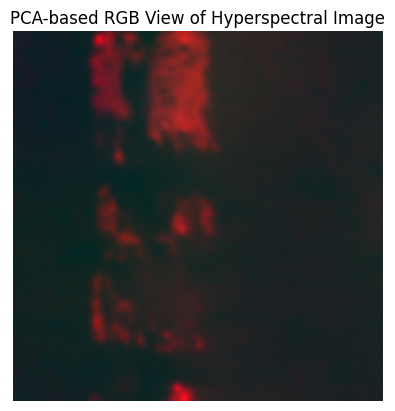

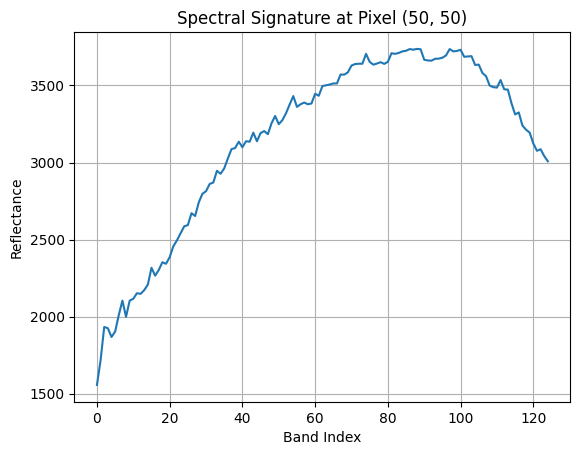

In [31]:
# ============================================
#            Middle Value Data 
# ============================================


data_Mid = np.load(f'{base_path}/sample130.npy')

print("Data shape:", data_Mid.shape)  # Print the shape of the data

# Get the label for this file from train_df
label = train_df[train_df['id'] == 'sample130.npy']['label'].iloc[0]
print(f"Label for sample130.npy: {label}")

# ---------- PCA Visualization ----------
H, W, C = data_Mid.shape
reshaped_data = data_Mid.reshape(-1, C)

# Apply PCA to reduce to 3 components
pca = PCA(n_components=3)
pca_data = pca.fit_transform(reshaped_data)

# Reshape back to image form
pca_image = pca_data.reshape(H, W, 3)

# Normalize for display
pca_image = (pca_image - np.min(pca_image)) / (np.max(pca_image) - np.min(pca_image))

# Display PCA RGB image
plt.imshow(pca_image)
plt.title("PCA-based RGB View of Hyperspectral Image")
plt.axis('off')
plt.show()

# ---------- Spectral Signature ----------
pixel_spectrum = data_Mid[64, 64, :] 

plt.plot(pixel_spectrum)
plt.title("Spectral Signature at Pixel (50, 50)")
plt.xlabel("Band Index")
plt.ylabel("Reflectance")
plt.grid(True)
plt.show()


Data shape: (128, 128, 125)
Label for sample271.npy: 0


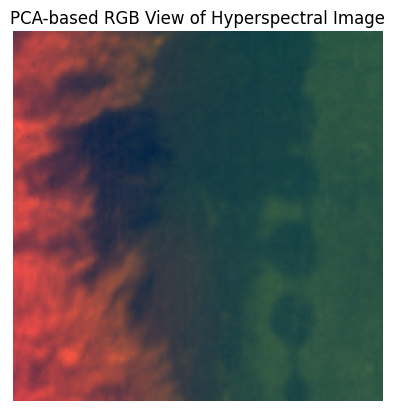

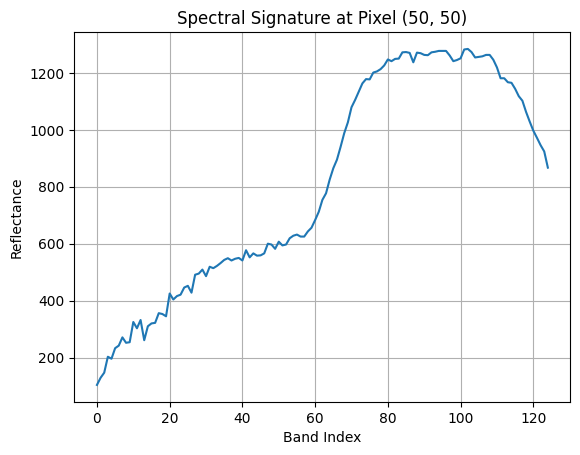

In [ ]:
# ============================================
#            Lowest Value Data 
# ============================================

data_Low = np.load(f'{base_path}/sample271.npy')

print("Data shape:", data_Low.shape)   # Print the shape of the data

# Get the label for this file from train_df
label = train_df[train_df['id'] == 'sample271.npy']['label'].iloc[0]
print(f"Label for sample271.npy: {label}")

# ---------- PCA Visualization ----------
H, W, C = data_Low.shape
reshaped_data = data_Low.reshape(-1, C)

# Apply PCA to reduce to 3 components
pca = PCA(n_components=3)
pca_data = pca.fit_transform(reshaped_data)

# Reshape back to image form
pca_image = pca_data.reshape(H, W, 3)

# Normalize for display
pca_image = (pca_image - np.min(pca_image)) / (np.max(pca_image) - np.min(pca_image))

# Display PCA RGB image
plt.imshow(pca_image)
plt.title("PCA-based RGB View of Hyperspectral Image")
plt.axis('off')
plt.show()

# ---------- Spectral Signature ----------
pixel_spectrum = data_Low[64, 64, :]  

plt.plot(pixel_spectrum)
plt.title("Spectral Signature at Pixel (50, 50)")
plt.xlabel("Band Index")
plt.ylabel("Reflectance")
plt.grid(True)
plt.show()


Highest:
Data shape: (128, 128, 125)
Label for sample1638.npy: 100

Middle:
Data shape: (128, 128, 125)
Label for sample130.npy: 49

Lowest:
Data shape: (128, 128, 125)
Label for sample271.npy: 0



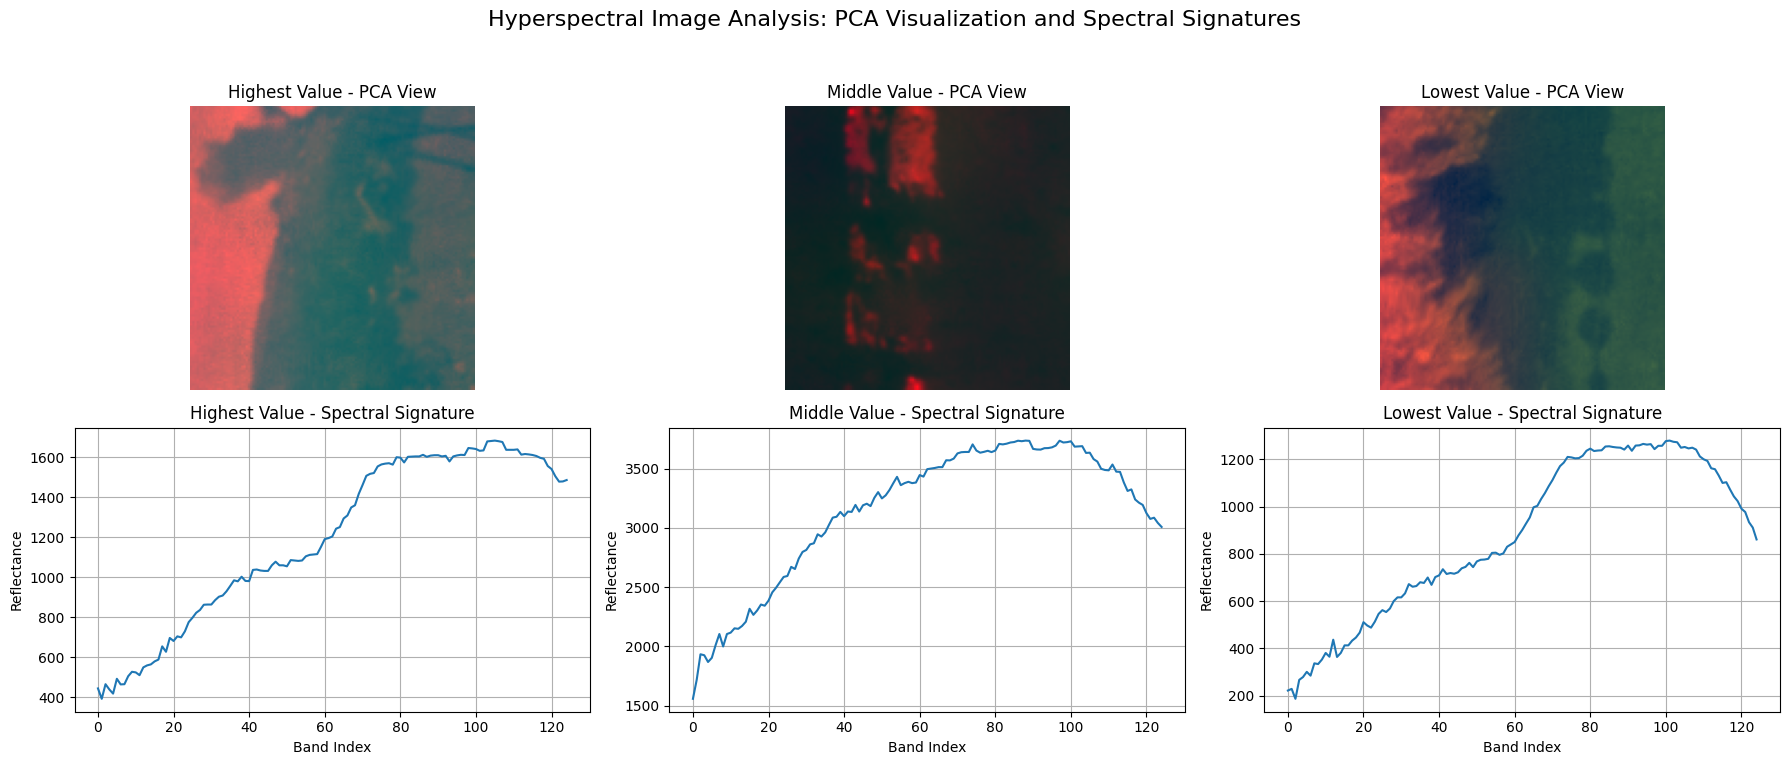

In [35]:
samples = [
    ('sample1638.npy', 'Highest'),
    ('sample130.npy', 'Middle'),
    ('sample271.npy', 'Lowest')
]

fig, axes = plt.subplots(2, 3, figsize=(18, 8))
fig.suptitle("Hyperspectral Image Analysis: PCA Visualization and Spectral Signatures", fontsize=16)

for i, (file_name, title) in enumerate(samples):
    print(f"{title}:")
    
    # Load data
    data = np.load(f'{base_path}/{file_name}')
    print(f"Data shape: {data.shape}")

    # Get label
    label = train_df[train_df['id'] == file_name]['label'].iloc[0]
    print(f"Label for {file_name}: {label}")

    H, W, C = data.shape

    # PCA processing
    reshaped_data = data.reshape(-1, C)
    pca = PCA(n_components=3)
    pca_data = pca.fit_transform(reshaped_data)
    pca_image = pca_data.reshape(H, W, 3)
    pca_image = (pca_image - np.min(pca_image)) / (np.max(pca_image) - np.min(pca_image))

    # Display PCA image
    axes[0, i].imshow(pca_image)
    axes[0, i].set_title(f'{title} Value - PCA View')
    axes[0, i].axis('off')

    # Plot spectral signature
    pixel_spectrum = data[64, 64, :]
    axes[1, i].plot(pixel_spectrum)
    axes[1, i].set_title(f'{title} Value - Spectral Signature')
    axes[1, i].set_xlabel("Band Index")
    axes[1, i].set_ylabel("Reflectance")
    axes[1, i].grid(True)

    print()  # Add a blank line between each section

plt.tight_layout(rect=(0, 0.03, 1, 0.95))
plt.show()

## CNN

In [ ]:
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(2, 8, kernel_size, padding=kernel_size//2),
            nn.ReLU(),
            nn.Conv2d(8, 1, kernel_size=1)
        )
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        concat = torch.cat([avg_out, max_out], dim=1)
        attention = self.sigmoid(self.conv(concat))
        return x * attention

class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction_ratio),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction_ratio, in_channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        avg_out = self.fc(self.avg_pool(x).view(b, c))
        max_out = self.fc(self.max_pool(x).view(b, c))
        out = avg_out + max_out
        return out.view(b, c, 1, 1)

class HyperspectralCNN(nn.Module):
    def __init__(self, in_channels=NUM_BANDS):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2)
        )
        
        self.ca1 = ChannelAttention(64)
        self.sa1 = SpatialAttention()
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2)
        )
        
        self.ca2 = ChannelAttention(128)
        self.sa2 = SpatialAttention()
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True),
            nn.AdaptiveAvgPool2d(1)
        )
        
        # using regression as the final layer to predict the score
        self.regressor = nn.Sequential(
            nn.Linear(256, 128),
            nn.SiLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.SiLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()  # Sigmoid to output between 0 and 1
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.ca1(x) * x
        x = self.sa1(x) * x
        
        x = self.conv2(x)
        x = self.ca2(x) * x
        x = self.sa2(x) * x
        
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        x = self.regressor(x)
        return x * 100  # Scale to 0-100 range

## Data set


In [34]:
class HyperspectralDataset(Dataset):
    def __init__(self, df, base_path, patch_size=64, augment=False, is_test=False):
        self.df = df
        self.base_path = base_path
        self.patch_size = patch_size
        self.augment = augment
        self.is_test = is_test
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # Get the NPY file path from the dataframe
        npy_file = self.df.iloc[idx]['id']  # Using 'id' column for both train and test
        
        # Load the NPY file
        data = np.load(f"{self.base_path}/{npy_file}")
        data = torch.from_numpy(data).float()
        
        # Reshape data to (channels, height, width)
        # Assuming input is (height, width, channels)
        if len(data.shape) == 3:
            data = data.permute(2, 0, 1)  # Change from (H, W, C) to (C, H, W)
        
        # Ensure we have exactly NUM_BANDS channels
        if data.shape[0] != NUM_BANDS:
            # If we have more channels, take the first NUM_BANDS
            # If we have fewer channels, pad with zeros
            if data.shape[0] > NUM_BANDS:
                data = data[:NUM_BANDS]
            else:
                padding = torch.zeros((NUM_BANDS - data.shape[0], data.shape[1], data.shape[2]))
                data = torch.cat([data, padding], dim=0)
        
        # Resize to fixed size using interpolation
        if data.shape[1] != self.patch_size or data.shape[2] != self.patch_size:
            data = F.interpolate(data.unsqueeze(0), size=(self.patch_size, self.patch_size), 
                               mode='bilinear', align_corners=False).squeeze(0)
        
        # Normalize data
        data = (data - data.mean()) / (data.std() + 1e-8)
        
        if self.is_test:
            # For test data, return only the data
            return data
        else:
            # For training data, return data and label
            disease_percentage = torch.tensor(self.df.iloc[idx]['label'], dtype=torch.float32)
            return data, disease_percentage

## Epoch Loop

In [35]:
class EarlyStopping:
    def __init__(self, patience=20, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [36]:
def plot_training_curves(train_losses, val_losses, train_maes, val_maes):
    """
    Plot training and validation curves for loss and MAE.
    """
    plt.close('all')  # <-- Add this to clear any previous figures

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))  # 1 row, 2 columns

    # Plot losses
    ax1.plot(train_losses, label='Train Loss', marker='o')
    ax1.plot(val_losses, label='Val Loss', marker='o')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot MAE
    ax2.plot(train_maes, label='Train MAE', marker='o')
    ax2.plot(val_maes, label='Val MAE', marker='o')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('MAE (%)')
    ax2.set_title('Training and Validation Mean Absolute Error')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

def plot_predictions_vs_actual(all_labels, all_preds):
    """
    Plot predictions against actual values.
    
    Args:
        all_labels (numpy.ndarray): Array of actual values
        all_preds (numpy.ndarray): Array of predicted values
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(all_labels, all_preds, alpha=0.5)
    plt.plot([0, 100], [0, 100], 'r--')  # Perfect prediction line
    plt.xlabel('Actual Disease Percentage')
    plt.ylabel('Predicted Disease Percentage')
    plt.title('Predicted vs Actual Disease Percentage')
    plt.grid(True)
    plt.show()

In [ ]:
def train_model(model, train_loader, val_loader, epochs, criterion, optimizer):
    scaler = GradScaler()
    train_losses = []
    train_maes = []  
    val_losses = []
    val_maes = []
    
    early_stopping = EarlyStopping(patience=PATIENCE)
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_mae = 0.0
        valid_samples = 0
        
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            
            if torch.isnan(inputs).any() or torch.isnan(labels).any():
                continue
                
            optimizer.zero_grad()
            with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
                outputs = model(inputs)
                if torch.isnan(outputs).any():
                    continue
                outputs = outputs.squeeze(-1)  # Remove last dimension if it's 1
                labels = labels.float()  # Ensure labels are float
                loss = criterion(outputs, labels)
            if not torch.isnan(loss):
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                train_loss += loss.item() * inputs.size(0)
                train_mae += torch.abs(outputs - labels).sum().item()
                valid_samples += inputs.size(0)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_mae = 0.0
        val_samples = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                outputs = outputs.squeeze(-1)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                val_mae += torch.abs(outputs - labels).sum().item()
                val_samples += inputs.size(0)
        
        if valid_samples > 0 and val_samples > 0:
            train_loss /= valid_samples
            train_mae /= valid_samples
            val_loss /= val_samples
            val_mae /= val_samples
            
            train_losses.append(train_loss)
            train_maes.append(train_mae)
            val_losses.append(val_loss)
            val_maes.append(val_mae)
            
            print(f"Epoch {epoch+1}:")
            print(f"Train Loss: {train_loss:.4f}, Train MAE: {train_mae:.2f}%")
            print(f"Val Loss: {val_loss:.4f}, Val MAE: {val_mae:.2f}%")
            
            # Save model after each epoch
            torch.save(model.state_dict(), 'disease_regression_model.pth')
            
            # Early stopping check
            early_stopping(val_loss)
            if early_stopping.early_stop:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break
        else:
            print(f"Epoch {epoch+1}: No valid training/validation samples")
    
    # Plot training curves using the new function
    plot_training_curves(train_losses, val_losses, train_maes, val_maes)
    
    return model

def evaluate_model(model, loader, criterion, device=DEVICE):
    model.eval()
    total_loss = 0.0
    total_mae = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            total_mae += torch.abs(outputs - labels).sum().item()
            
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(loader.dataset)
    avg_mae = total_mae / len(loader.dataset)
    
    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Test MAE: {avg_mae:.2f}%")
    
    # Plot predictions vs actual using the new function
    plot_predictions_vs_actual(np.array(all_labels), np.array(all_preds))
    
    return avg_loss, np.array(all_preds), np.array(all_labels)

## Main

Epoch 1/3:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 1:
Train Loss: 875.5982, Train MAE: 25.69%
Val Loss: 872.9066, Val MAE: 25.66%


Epoch 2/3:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 2:
Train Loss: 870.1071, Train MAE: 25.65%
Val Loss: 867.8631, Val MAE: 25.61%


Epoch 3/3:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 3:
Train Loss: 867.2116, Train MAE: 25.59%
Val Loss: 864.4152, Val MAE: 25.55%


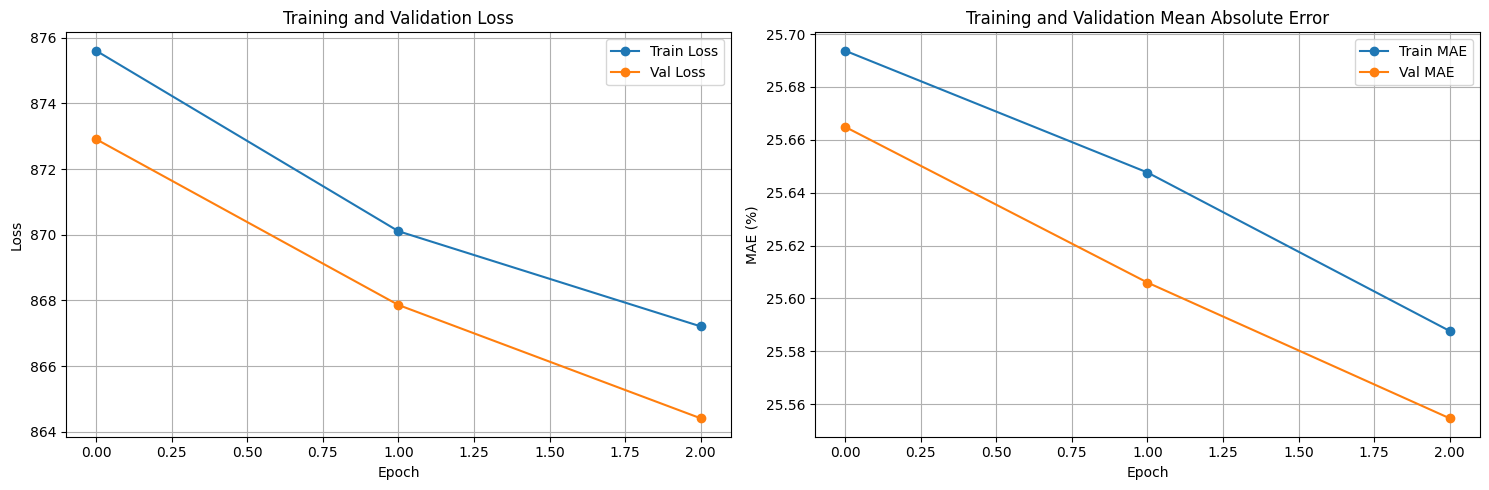

Making predictions:   0%|          | 0/18 [00:00<?, ?it/s]

In [ ]:
# Load training and test data
train_df = pd.read_csv('C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/train.csv')
test_df = pd.read_csv('C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/test.csv')
base_path = 'C:/IIUM/AI Note IIUM/Deep_Learning/Project/Data/ot'

# Create datasets
train_dataset = HyperspectralDataset(train_df, base_path, augment=True, is_test=False)
val_dataset = HyperspectralDataset(train_df, base_path, augment=False, is_test=False)  
test_dataset = HyperspectralDataset(test_df, base_path, augment=False, is_test=True)

# Create data loaders with num_workers=0
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Initialize model and training components
model = HyperspectralCNN().to(DEVICE)
criterion = nn.MSELoss()  # Mean Squared Error loss for regression
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Train model
model = train_model(model, train_loader, val_loader, EPOCHS, criterion, optimizer)

# Make predictions on test set
model.eval()
all_preds = []
all_files = []

with torch.no_grad():
    for inputs in tqdm(test_loader, desc="Making predictions"):
        inputs = inputs.to(DEVICE)
        outputs = model(inputs)
        all_preds.extend(outputs.cpu().numpy())
        all_files.extend(test_df['id'].iloc[len(all_files):len(all_files)+len(inputs)].values)

# Save predictions to CSV
results_df = pd.DataFrame({
    'id': all_files,
    'predicted_percentage': all_preds
})
results_df.to_csv('test_predictions.csv', index=False)

## View Distribution

In [1]:
df_pred = pd.read_csv('C:/IIUM/AI Note IIUM/Deep_Learning/Project/test_predictions.csv')
df_pred['predicted_percentage'] = df_pred['predicted_percentage'].str.strip('[]').astype(float)

plt.hist(df_pred['predicted_percentage'], bins=30,)
plt.xlabel('Predicted Disease Percentage')
plt.ylabel('Count')
plt.title('Distribution of Test Set Predictions')
plt.show()

NameError: name 'pd' is not defined